In [1]:
import copy
import h5py
import itertools
import numpy as np
import scipy
import scipy.interpolate

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import palettable

In [3]:
import emcee
import kalepy as kale

In [4]:
import verdict

# Scratch

In [5]:
colors = palettable.cartocolors.qualitative.Safe_10.mpl_colors

In [6]:
colormap = palettable.matplotlib.Viridis_10.mpl_colormap

# Load and Format Data

Units are [ g/cm^3, mass fraction, logK, log cm^-2 ] respectively for ['Density', 'Metallicity', 'Temperature', 'hneutralssh'].

In [7]:
fp = './data/EAGLE/histogram_galaxies_logM200c-Msun-12.0-12.5_200_seed0_hneutralssh.hdf5'
f = h5py.File( fp, 'r' )

In [8]:
# Get centers, reformat edges

histogram_axes = [ 'Temperature', 'Density', 'Metallicity', 'hneutralssh' ]
centers = []
bins = []
dxs = []
for i, key in enumerate( histogram_axes ):
    
    arr = copy.copy( f['histogram_axes'][key][...] )
    dx = arr[2] - arr[1]
    
    # For convenience, let's not have a -inf edge lying around
    if key == 'Metallicity':
        arr[0] = arr[1] - dx
        
    centers_i = arr[:-1] + 0.5 * dx
    
    dxs.append( dx )
    centers.append( centers_i )
    bins.append( arr )

In [9]:
# Normalize into a pdf

norm = f['histogram'][...].sum() * dxs[0] * dxs[1] * dxs[2] * dxs[3]
pdf = f['histogram'][...] / norm

In [10]:
# Sample points from the histogram

kde = kale.KDE.from_hist(
    bins,
    pdf,
    reflect = [
        None,
        None,
        [ None, 0. ],
        None,
    ],
)
sample = kde.resample( 100 )

In [11]:
# Create the interpolation function
def prob_fn( temp, den, met, hi ):
    
    return scipy.interpolate.interpn( centers, pdf, [ temp, den, met, hi ] )[0]

In [12]:
# Find the peak

max_ind = np.argmax( pdf, )
max_inds = np.unravel_index( max_ind, f['histogram'][...].shape )
max_value = np.max( pdf )
p0 = tuple( [ centers[i][max_inds[i]] for i in range( len( max_inds ) ) ] )

In [13]:
# Check work

print( 'If these two values are consistent then interpolation is working correctly.' )
print( '    max value = {:.3g}, max interpolated value = {:.3g}'.format( max_value, prob_fn( *p0 ) ) )

If these two values are consistent then interpolation is working correctly.
    max value = 0.199, max interpolated value = 0.199


In [14]:
probs = []
for sample_i in sample.transpose():
    
    try:
        probs.append( prob_fn( *sample_i ) )
    except ValueError:
        probs.append( np.nan )

In [15]:
# Set up combinations to iterate through
inds = range( len( histogram_axes ) )
combinations = [ _ for _ in itertools.combinations( inds, 2 ) ]

<ipython-input-20-6e6dcc480476>:16: RuntimeWarning: divide by zero encountered in log10
  np.log10( projection ),


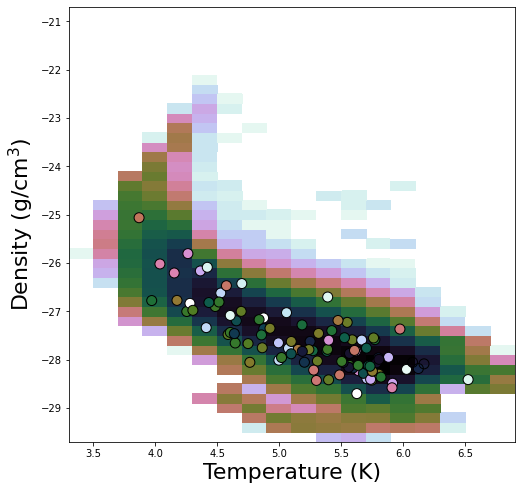

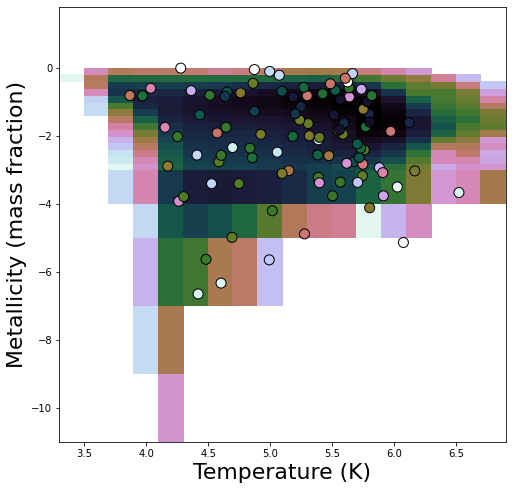

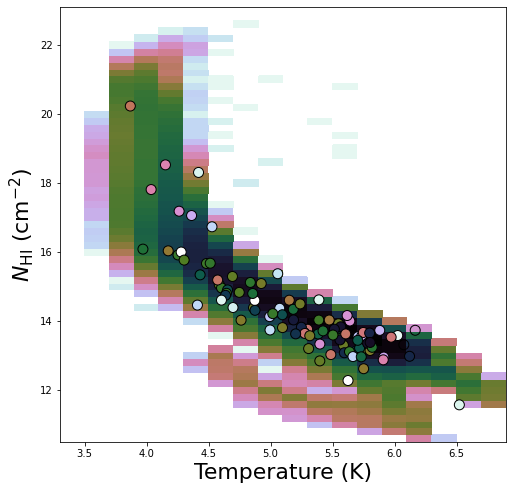

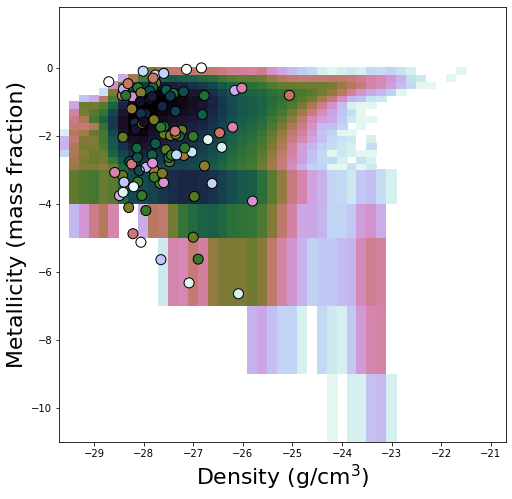

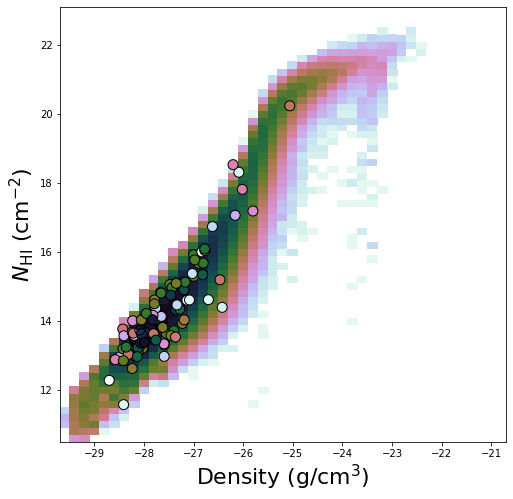

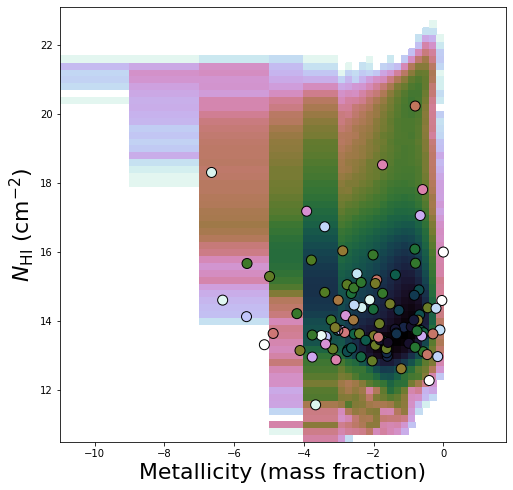

In [20]:
labels = [ 'Temperature (K)', r'Density (g/cm$^{3}$)', 'Metallicity (mass fraction)', r'$N_{\rm HI}$ (cm$^{-2}$)' ]
for k, (i, j) in enumerate( combinations ):
    
    # Show data
    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    sum_axes = copy.copy( list( inds ) )
    sum_axes.remove( i )
    sum_axes.remove( j )
    projection = pdf.sum( axis=tuple( sum_axes ) ).transpose()
    x, y = np.meshgrid( centers[i], centers[j] )
    ax.pcolormesh(
        centers[i],
        centers[j],
        np.log10( projection ),
        cmap = 'cubehelix_r',
    )
    
    ax.scatter(
        sample[i],
        sample[j],
        edgecolor = 'k',
        s = 100,
        c = probs,
        vmin = np.nanmin( pdf[np.nonzero(pdf)] ),
        vmax = np.nanmax( pdf[np.nonzero(pdf)] ),
        cmap = palettable.cubehelix.classic_16_r.mpl_colormap,
        norm = matplotlib.colors.LogNorm(),
    )

    
    ax.set_xlabel( labels[i], fontsize=22 )
    ax.set_ylabel( labels[j], fontsize=22 )
    
    ax.set_aspect( 'auto' )